In [1]:
import numpy as np
import pandas as pd

train_path = "X_train.csv"
label_path = "y_train.csv"
test_path = "X_test.csv"
samples_path = "samples.csv"

df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
labeldf = pd.read_csv(label_path)


labels = labeldf.values
data = df.values
test_data = test_df.values

data = data[:,1:]
test_data = test_data[:,1:]
labels = labels[:,1]


print(data.shape)
print(test_data.shape)
print(labels.shape)



(5117, 17813)
(3411, 17813)
(5117,)


In [2]:
def count_instances(labels):
    unique, counts = np.unique(labels,return_counts=True)
    return dict(zip(unique,counts))

class_counts = count_instances(labels)

print("Class 0 Counts: {}".format(class_counts[0]))
print("Class 1 Counts: {}".format(class_counts[1]))
print("Class 2 Counts: {}".format(class_counts[2]))
print("Class 3 Counts: {}".format(class_counts[3]))


(num_train, max_timesteps) = data.shape
(num_test, _) = test_data.shape

Class 0 Counts: 3030
Class 1 Counts: 443
Class 2 Counts: 1474
Class 3 Counts: 170


In [62]:
def find_centerwave(templates):
    n_short = len(templates)
    dist_mat = np.zeros([n_short, n_short])
    for i in range(n_short):
        dist_mat[i, i] = 0.0
        for j in range(i+1, n_short):
            tmp_dist = dist(templates[i], templates[j])
            dist_mat[i, j] = tmp_dist
            dist_mat[j, i] = tmp_dist

    dist_mat_dist = np.sum(dist_mat, axis=1)
    centerwave = templates[np.argsort(dist_mat_dist)[0]]
    return centerwave

In [63]:
def dist(ts1, ts2):
    '''
    Input: two vectors
    Output: distance, numeric
    '''
    dist_num = np.linalg.norm(np.array(ts1) - np.array(ts2))
    return dist_num

In [64]:
def fftanalysis(signal, rate=300, first=8):
    try:
        fftsignal = np.abs(np.fft.fft(signal))**2
        if len(fftsignal < 8):
            fftsignal = np.append(fftsignal, np.zeros(first - len(fftsignal)))
    except Exception:
        fftsignal = np.zeros(first)
    # print(fftsignal)
    # freqs = np.fft.fftfreq(len(signal), d=1 / rate)
    # print(freqs)
    # plt.bar(freqs[:first], fftsignal[:first])
    # plt.show()
    return fftsignal[:first]

In [75]:
   def centerwave_wave_feature(ts):
    '''
    ### 4
    Electrocardiogram Feature Extraction and Pattern Recognition Using a Novel Windowing Algorithm
        
    TODO: more on how to detect PT waves
    '''

    feat = []


    ### key points
    T_start = round(0.15 * len(ts))
    T_end = round(0.55 * len(ts))
    P_start = round(0.65 * len(ts))
    P_end = round(0.95 * len(ts))
    
    T_wave = ts[T_start:T_end]
    P_wave = ts[P_start:P_end]
    
    T_peak = max(T_wave)
    P_peak = max(P_wave)
    Q_peak = min(ts[-6:])
    R_peak = ts[0]
    S_peak = min(ts[:6])
    
    T_loc = np.argmax(T_wave)
    P_loc = np.argmax(P_wave)
    Q_loc = -np.argmin(ts[-6:]) - len(ts)
    R_loc = 0
    S_loc = np.argmin(ts[:6])
                    
    
    ### features (5)
    PR_interval = P_loc - 0
    QRS_duration = S_loc - Q_loc
    QT_interval = T_loc - Q_loc
    QT_corrected = QT_interval / len(ts)
    if QRS_duration == 0:
        vent_rate = 0
    else:
        vent_rate = 1 / QRS_duration
    
    ### number of f waves (2)
    TQ_interval = ts[T_loc:Q_loc]
    thres = np.mean(TQ_interval) + (T_peak - np.mean(TQ_interval))/50
    NF, Fwidth = LongThresCrossing(TQ_interval, thres)
        
    ### more features (16)
    RQ_amp = R_peak - Q_peak
    RS_amp = R_peak - S_peak
    ST_amp = T_peak - S_peak
    PQ_amp = P_peak - Q_peak
    QS_amp = Q_peak - S_peak
    RP_amp = R_peak - P_peak
    RT_amp = R_peak - T_peak
    
    ST_interval = T_loc - S_loc
    RS_interval = S_loc - R_loc
    
    T_peak = T_peak
    P_peak = P_peak
    Q_peak = Q_peak
    R_peak = R_peak
    S_peak = S_peak
    
    if RS_interval == 0:
        RS_slope = 0
    else:
        RS_slope = RS_amp / RS_interval                
    if ST_interval == 0:
        ST_slope = 0
    else:
        ST_slope = ST_amp / ST_interval
    
    
    ### 
    feat.append(PR_interval)
    feat.append(QRS_duration)
    feat.append(QT_interval)
    feat.append(QT_corrected)
    feat.append(vent_rate)
    
    feat.append(NF)
    feat.append(Fwidth)

    feat.append(RQ_amp)
    feat.append(RS_amp)
    feat.append(ST_amp)
    feat.append(PQ_amp)
    feat.append(QS_amp)
    feat.append(RP_amp)
    feat.append(RT_amp)
    feat.append(ST_interval)
    feat.append(RS_interval)
    feat.append(T_peak)
    feat.append(P_peak)
    feat.append(Q_peak)
    feat.append(R_peak)
    feat.append(S_peak)
    feat.append(RS_slope)
    feat.append(ST_slope)
    
    return feat

In [76]:

##################################################
### tools
##################################################
def zigzag(ts):
    '''
    number of zigzag
    '''
    num_zigzag = 1
    for i in range(len(ts)-2):
        num_1 = ts[i]
        num_2 = ts[i+1]
        num_3 = ts[i+2]
        if (num_2 - num_1) * (num_3 - num_2) < 0:
            num_zigzag += 1
    return num_zigzag

def dist(ts1, ts2):
    '''
    Input: two vectors
    Output: distance, numeric
    '''
    dist_num = np.linalg.norm(np.array(ts1) - np.array(ts2))
    return dist_num

def resample_unequal(ts, length):
    '''
    TODO: 
        1. average of several points
    '''
    resampled = [0.0] * length
    resampled_idx = list(np.linspace(0.0, len(ts)-1, length))
    for i in range(length):
        idx_i = resampled_idx[i]
        low_idx = int(np.floor(idx_i))
        low_weight = abs(idx_i - np.ceil(idx_i))
        high_idx = int(np.ceil(idx_i))
        high_weight = abs(idx_i - np.floor(idx_i))
        resampled[i] = low_weight * ts[low_idx] + high_weight * ts[high_idx]
#        print(idx_i, resampled[i], low_weight, high_weight)
#        break
    return resampled

def LongThresCrossing(ts, thres):
    cnt = 0
    pair_flag = 1
    pre_loc = 0
    width = []
    for i in range(len(ts)-1):
        if (ts[i] - thres) * (ts[i+1] - thres) < 0:
            cnt += 1
            if pair_flag == 1:
                width.append(i-pre_loc)
                pair_flag = 0
            else:
                pair_flag = 1
                pre_loc = i
        if ts[i] == thres and (ts[i-1] - thres) * (ts[i+1] - thres) < 0:
            cnt += 1
    
    if len(width) > 1:
        return [cnt, np.mean(width)]
    else:
        return [cnt, 0.0]

def autocorr(ts, t):
    return np.corrcoef(np.array([ts[0:len(ts)-t], ts[t:len(ts)]]))[0,1]


##################################################
### get features
##################################################
def centerwave_simp(ts):
    '''
    ### 1
    resample centerwave to length 200, as features directly
    '''
    length = 200
    resampled_center_wave_raw = resample_unequal(ts, length)
    return resampled_center_wave_raw

def centerwave_zero_crossing(ts):
    '''
    ### 2
    '''

    cnt = 0
    for i in range(len(ts)-1):
        if ts[i] * ts[i+1] < 0:
            cnt += 1
        if ts[i] == 0 and ts[i-1] * ts[i+1] < 0:
            cnt += 1
    return [cnt]

def centerwave_basic_stat(ts):
    '''
    ### 3
    stat feat
    '''

    
    length = len(ts)
    area = np.sum(np.abs(ts))
    
    Max = max(ts)
    Min = min(ts)
    Range = max(ts) - min(ts)
    Var = np.var(ts)
    Skew = stats.skew(ts)
    Kurtosis = stats.kurtosis(ts)
    Median = np.median(ts)

    p_1 = np.percentile(ts, 1)
    p_5 = np.percentile(ts, 5)
    p_10 = np.percentile(ts, 10)
    p_25 = np.percentile(ts, 25)
    p_75 = np.percentile(ts, 75)
    p_90 = np.percentile(ts, 90)
    p_95 = np.percentile(ts, 95)
    p_99 = np.percentile(ts, 99)

    range_99_1 = p_99 - p_1
    range_95_5 = p_95 - p_5
    range_90_10 = p_90 - p_10
    range_75_25 = p_75 - p_25

    
    return [length, area, 
            Max, Min, Range, Var, Skew, Kurtosis, Median, 
            p_1, p_5, p_95, p_99, 
            p_10, p_25, p_75, p_90, 
            range_99_1, range_95_5, range_90_10, range_75_25]

def centerwave_wave_feature(ts):
    '''
    ### 4
    Electrocardiogram Feature Extraction and Pattern Recognition Using a Novel Windowing Algorithm
        
    TODO: more on how to detect PT waves
    '''

    feat = []


    ### key points
    T_start = round(0.15 * len(ts))
    T_end = round(0.55 * len(ts))
    P_start = round(0.65 * len(ts))
    P_end = round(0.95 * len(ts))
    
    T_wave = ts[T_start:T_end]
    P_wave = ts[P_start:P_end]
    
    T_peak = max(T_wave)
    P_peak = max(P_wave)
    Q_peak = min(ts[-6:])
    R_peak = ts[0]
    S_peak = min(ts[:6])
    
    T_loc = np.argmax(T_wave)
    P_loc = np.argmax(P_wave)
    Q_loc = -np.argmin(ts[-6:]) - len(ts)
    R_loc = 0
    S_loc = np.argmin(ts[:6])
                    
    
    ### features (5)
    PR_interval = P_loc - 0
    QRS_duration = S_loc - Q_loc
    QT_interval = T_loc - Q_loc
    QT_corrected = QT_interval / len(ts)
    if QRS_duration == 0:
        vent_rate = 0
    else:
        vent_rate = 1 / QRS_duration
    
    ### number of f waves (2)
    TQ_interval = ts[T_loc:Q_loc]
    thres = np.mean(TQ_interval) + (T_peak - np.mean(TQ_interval))/50
    NF, Fwidth = LongThresCrossing(TQ_interval, thres)
        
    ### more features (16)
    RQ_amp = R_peak - Q_peak
    RS_amp = R_peak - S_peak
    ST_amp = T_peak - S_peak
    PQ_amp = P_peak - Q_peak
    QS_amp = Q_peak - S_peak
    RP_amp = R_peak - P_peak
    RT_amp = R_peak - T_peak
    
    ST_interval = T_loc - S_loc
    RS_interval = S_loc - R_loc
    
    T_peak = T_peak
    P_peak = P_peak
    Q_peak = Q_peak
    R_peak = R_peak
    S_peak = S_peak
    
    if RS_interval == 0:
        RS_slope = 0
    else:
        RS_slope = RS_amp / RS_interval                
    if ST_interval == 0:
        ST_slope = 0
    else:
        ST_slope = ST_amp / ST_interval
    
    
    ### 
    feat.append(PR_interval)
    feat.append(QRS_duration)
    feat.append(QT_interval)
    feat.append(QT_corrected)
    feat.append(vent_rate)
    
    feat.append(NF)
    feat.append(Fwidth)

    feat.append(RQ_amp)
    feat.append(RS_amp)
    feat.append(ST_amp)
    feat.append(PQ_amp)
    feat.append(QS_amp)
    feat.append(RP_amp)
    feat.append(RT_amp)
    feat.append(ST_interval)
    feat.append(RS_interval)
    feat.append(T_peak)
    feat.append(P_peak)
    feat.append(Q_peak)
    feat.append(R_peak)
    feat.append(S_peak)
    feat.append(RS_slope)
    feat.append(ST_slope)
    
    return feat

def centerwave_autocorr(ts):
    '''
    ### 5
    auto-coefficient, with lag
    '''
    feat = []
    num_lag = 12
    
    
    for i in range(num_lag):
        feat.append(autocorr(ts, i))

    return feat

def centerwave_zigzag(ts):
    '''
    ### 6
    number of zigzag in centerwave
    '''
    num_zigzag = zigzag(ts)
    return [num_zigzag]
        


In [77]:
import sys
from biosppy.signals import tools as st
from biosppy.signals.ecg import correct_rpeaks, extract_heartbeats, hamilton_segmenter, ecg
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import argrelmax
from scipy.stats import stats

from scipy.stats import stats
from sklearn.metrics import f1_score
from biosppy import plotting, utils
          
    
def process_data(data, sampling_rate=300, show=False, verbose=True):
    x = []
    nanplaces = np.isnan(data)
    for i, signal in enumerate(data):
        stop_index = np.argmax(nanplaces[i,:]==True)-1
        temp = ecg(signal=signal[:stop_index],
                      sampling_rate=sampling_rate,
                      show=show
                      #segmenter=qrs_detector
                      )
        args = (data[i], temp["ts"], temp["filtered"], temp["rpeaks"],
                temp["templates_ts"], temp["templates"], temp["heart_rate_ts"],
                temp["heart_rate"])
        names = ('original', 'ts', 'filtered', 'rpeaks', 'templates_ts',
                 'templates', 'heart_rate_ts', 'heart_rate')
        temp = utils.ReturnTuple(args, names)
        x.append(temp)
        
        if verbose:
            if i % 300 == 0:
                print("Analysing sample ", i, "...Please wait...")
                sys.stdout.flush()
                
    return x

def signal_stats(signal):
    try:
        # mean, median, max, min, std, skewness, kurtosis
        # check inputs
        if signal is None:
            raise TypeError("Please specify an input signal.")

        # ensure numpy
        signal = np.array(signal)

        # mean
        mean = np.mean(signal)

        # median
        median = np.median(signal)

        # maximum amplitude abs
        maxAmpAbs = np.abs(signal - mean).max()

        # minimum amplitude abs
        minAmpAbs = np.abs(signal - mean).min()

        # maximum amplitude
        maxAmp = (signal - mean).max()

        # minimum amplitude
        minAmp = (signal - mean).min()

        # variance
        sigma2 = signal.var(ddof=1)

        # standard deviation
        sigma = signal.std(ddof=1)

        # absolute deviation
        ad = np.sum(np.abs(signal - median))

        # kurtosis
        kurt = stats.kurtosis(signal, bias=False)

        # skweness
        skew = stats.skew(signal, bias=False)
        
        # SNR
        snr = stats.signaltonoise(signal)
            
        # Entropy
        entropy = stats.entropy(signal)
        
        # Z-score
        
        zscore = stats.zscore(signal)
        
        # 3rd 4th, Moment
        
        mom3 = stats.moment(signal,3)
        mom4 = stats.moment(signal,4)
        
        # output
        args = (mean, median, maxAmpAbs, minAmpAbs, maxAmp, minAmp, sigma2,
                sigma, ad, kurt, skew )#, snr, entropy zscore, mom3, mom4)
        names = ('mean', 'median', 'maxabs', 'minabs', 'max', 'min', 'var',
                 'std_dev', 'abs_dev', 'kurtosis', 'skewness')#,"snr", "entropy")#"zscore","mom3","mom4")

        return utils.ReturnTuple(args, names)
    except Exception:
        args = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)#,0,0)#,0,0,0)
        names = ('mean', 'median', 'maxabs', 'minabs', 'max', 'min', 'var',
                 'std_dev', 'abs_dev', 'kurtosis', 'skewness')#,"snr", "entropy")#"zscore","mom3","mom4")

        return utils.ReturnTuple(args, names)
    
def RRIntervals(qrs_indices, sampling_rate=300):
    RR = np.diff(qrs_indices) / sampling_rate
    return RR

def extract_data(biooutput, sampling_rate=300):
    original_signal = biooutput["original"]
    filtered_signal = biooutput["filtered"]
    median_template = np.median(biooutput["templates"], axis=0)
    # plt.plot(median_template)
    mean_template = np.mean(biooutput["templates"], axis=0)
    std_template = np.std(biooutput["templates"], axis=0)

    # plt.plot(std_template)
    # plt.show()
    if len(median_template) == 0:
        median_template = np.zeros((0.6 * sampling_rate))
        mean_template = np.zeros((0.6 * sampling_rate))
        std_template = np.zeros((0.6 * sampling_rate))

    if len(biooutput["heart_rate"]) == 0:
        heart_rate = [0]
    else:
        heart_rate = biooutput["heart_rate"]

    if len(biooutput["rpeaks"]) == 0:
        rpeaks = [0]
    else:
        rpeaks = biooutput["rpeaks"]

    median_template_stats = signal_stats(median_template)
    mean_template_stats = signal_stats(mean_template)
    heartrate_stats = signal_stats(heart_rate)

    peak_values = original_signal[rpeaks]
    peak_stats = signal_stats(peak_values)

    rrintervals = RRIntervals(rpeaks)
    rrinterval_stats = signal_stats(rrintervals)

    median_temp_perc = np.percentile(median_template,
                                     [5, 15, 25, 35, 65, 75, 85, 95])
    mean_temp_perc = np.percentile(mean_template,
                                   [5, 15, 25, 35, 65, 75, 85, 95])
    heart_rate_perc = np.percentile(heart_rate,
                                    [5, 15, 25, 35, 65, 75, 85, 95])
    peak_perc = np.percentile(peak_values, [5, 15, 25, 35, 65, 75, 85, 95])

    rrinterval2 = np.diff(rrintervals)
    rrinterval2_stats = signal_stats(rrinterval2)
    
    rr50 = np.sum(rrinterval2 > 0.05)
    rr20 = np.sum(rrinterval2 > 0.02)
    prr50 = rr50 / len(rrinterval2)
    prr20 = rr20 / len(rrinterval2)
    hrv_data = np.array([rr50, rr20, prr50, prr20])

    numofpeaks = len(biooutput["rpeaks"])

    return (filtered_signal, median_template, mean_template, std_template,
            median_template_stats, mean_template_stats, heartrate_stats,
            peak_stats, rrinterval_stats, median_temp_perc, mean_temp_perc,
            heart_rate_perc, peak_perc, rrinterval2_stats, hrv_data,
            numofpeaks)


def featurevector(processed_signal, sampling_rate=300):
    results = extract_data(processed_signal, sampling_rate=sampling_rate)
    filtered_signal = results[0]
    median_template = results[1]
    mean_template = results[2]
    std_template = results[3]
    median_template_stats = list(results[4].as_dict().values())
    mean_template_stats = list(results[5].as_dict().values())
    heartrate_stats = list(results[6].as_dict().values())
    peak_stats = list(results[7].as_dict().values())
    rr_interval_stats = list(results[8].as_dict().values())
    median_temp_perc = results[9]
    mean_temp_perc = results[10]
    heart_rate_perc = results[11]
    peak_perc = results[12]
    rrinterval2_stats = list(results[13].as_dict().values())
    hrv_data = results[14]
    numofpeaks = results[14]
    centerwave = find_centerwave(processed_signal["templates"])
    #fourier = fftanalysis(processed_signal["filtered"])
    
    centerwave_wave = centerwave_wave_feature(centerwave)
    
    centerwave_sim = centerwave_simp(centerwave)
    
    centerwave_zero_crossin = centerwave_zero_crossing(centerwave)
    
    centerwave_autocor = centerwave_autocorr(centerwave)
    
    centerwave_zigza = centerwave_zigzag(centerwave)
    
     
       
    features = np.array([])
    features = np.append(features, median_template)
    features = np.append(features, mean_template)
    features = np.append(features, std_template)
    features = np.append(features, median_template_stats)
    features = np.append(features, mean_template_stats)
    features = np.append(features, heartrate_stats)
    features = np.append(features, peak_stats)
    features = np.append(features, rr_interval_stats)
    features = np.append(features, median_temp_perc)
    features = np.append(features, mean_temp_perc)
    features = np.append(features, heart_rate_perc)
    features = np.append(features, peak_perc)
    features = np.append(features, rrinterval2_stats)
    features = np.append(features, hrv_data)
    features = np.append(features, numofpeaks)
    #features = np.append(features, centerwave)
    features = np.append(features, centerwave_wave)
    features = np.append(features, centerwave_sim)
    features = np.append(features, centerwave_zero_crossin)
    features = np.append(features, centerwave_autocor)
    features = np.append(features, centerwave_zigza)

    #features = np.append(features, fourier)

    return filtered_signal, features


In [78]:
X1 = data


X2 = np.array([])
processed = process_data(X1, sampling_rate=300, show=False, verbose=True)

_, temp = featurevector(processed[0], sampling_rate=300)
new_length = len(temp)
all_features = np.empty((X1.shape[0], new_length))
for i in range(X1.shape[0]):
        filtered_signal, features = featurevector(processed[i], sampling_rate=300)
        assert all_features.shape[1] == len(features)
        all_features[i, :] = features
        #print(filtered_signal.shape)
        
        #X1[i, :] = filtered_signal

        if i % 10 == 0:
            print("Extracting features from sample", i)
            sys.stdout.flush()

X2 = X2.reshape(X1.shape[0], -1)
X2 = np.hstack((X2, all_features))

Analysing sample  0 ...Please wait...
Analysing sample  300 ...Please wait...
Analysing sample  600 ...Please wait...
Analysing sample  900 ...Please wait...
Analysing sample  1200 ...Please wait...
Analysing sample  1500 ...Please wait...
Analysing sample  1800 ...Please wait...
Analysing sample  2100 ...Please wait...
Analysing sample  2400 ...Please wait...
Analysing sample  2700 ...Please wait...
Analysing sample  3000 ...Please wait...
Analysing sample  3300 ...Please wait...
Analysing sample  3600 ...Please wait...
Analysing sample  3900 ...Please wait...
Analysing sample  4200 ...Please wait...
Analysing sample  4500 ...Please wait...
Analysing sample  4800 ...Please wait...
Analysing sample  5100 ...Please wait...
Extracting features from sample 0


/home/matthias/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/matthias/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Extracting features from sample 10
Extracting features from sample 20
Extracting features from sample 30
Extracting features from sample 40
Extracting features from sample 50
Extracting features from sample 60
Extracting features from sample 70
Extracting features from sample 80
Extracting features from sample 90
Extracting features from sample 100
Extracting features from sample 110
Extracting features from sample 120
Extracting features from sample 130
Extracting features from sample 140
Extracting features from sample 150
Extracting features from sample 160
Extracting features from sample 170
Extracting features from sample 180
Extracting features from sample 190
Extracting features from sample 200
Extracting features from sample 210
Extracting features from sample 220
Extracting features from sample 230
Extracting features from sample 240
Extracting features from sample 250
Extracting features from sample 260
Extracting features from sample 270
Extracting features from sample 280
E

/home/matthias/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/matthias/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/matthias/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


Extracting features from sample 640
Extracting features from sample 650
Extracting features from sample 660
Extracting features from sample 670
Extracting features from sample 680
Extracting features from sample 690
Extracting features from sample 700
Extracting features from sample 710
Extracting features from sample 720
Extracting features from sample 730
Extracting features from sample 740
Extracting features from sample 750
Extracting features from sample 760
Extracting features from sample 770
Extracting features from sample 780
Extracting features from sample 790
Extracting features from sample 800
Extracting features from sample 810
Extracting features from sample 820
Extracting features from sample 830
Extracting features from sample 840
Extracting features from sample 850
Extracting features from sample 860
Extracting features from sample 870
Extracting features from sample 880
Extracting features from sample 890
Extracting features from sample 900
Extracting features from sam

Extracting features from sample 2870
Extracting features from sample 2880
Extracting features from sample 2890
Extracting features from sample 2900
Extracting features from sample 2910
Extracting features from sample 2920
Extracting features from sample 2930
Extracting features from sample 2940
Extracting features from sample 2950
Extracting features from sample 2960
Extracting features from sample 2970
Extracting features from sample 2980
Extracting features from sample 2990
Extracting features from sample 3000
Extracting features from sample 3010
Extracting features from sample 3020
Extracting features from sample 3030
Extracting features from sample 3040
Extracting features from sample 3050
Extracting features from sample 3060
Extracting features from sample 3070
Extracting features from sample 3080
Extracting features from sample 3090
Extracting features from sample 3100
Extracting features from sample 3110
Extracting features from sample 3120
Extracting features from sample 3130
E

Extracting features from sample 5090
Extracting features from sample 5100
Extracting features from sample 5110


In [ ]:
X1 = test_data

X_test = np.array([])
processed = process_data(X1, sampling_rate=300, show=False, verbose=True)

_, temp = featurevector(processed[0], sampling_rate=300)
new_length = len(temp)
all_features = np.empty((X1.shape[0], new_length))
for i in range(X1.shape[0]):
        filtered_signal, features = featurevector(processed[i], sampling_rate=300)
        assert all_features.shape[1] == len(features)
        all_features[i, :] = features
        #print(filtered_signal.shape)
        
        #X1[i, :] = filtered_signal

        if i % 300 == 0:
            print("Extracting features from sample", i)
            sys.stdout.flush()

X_test = X_test.reshape(X1.shape[0], -1)
X_test = np.hstack((X_test, all_features))

In [52]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit_transform(X2)
scaler.transform(X_test)

ValueError: operands could not be broadcast together with shapes (3411,826) (849,) (3411,826) 

In [79]:
# One vs. All for class 3
# Gave lower validation score... (sadface)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

"""
X_2_3 = X2[np.argwhere(labels==3)]
X_2_rest = X2[np.argwhere(np.logical_or((labels==1) ,(labels==2) , (labels==0)))]
labels_rest = labels[np.argwhere(np.logical_or((labels==1) ,(labels==2) , (labels==0)))]

y_onevsall = np.zeros((X2.shape[0],1))
y_onevsall[np.argwhere(labels==3)] = 0
y_onevsall[np.argwhere(np.logical_or((labels==1) ,(labels==2) , (labels==0)))] = 1
y_onevsall = y_onevsall.reshape(X2.shape[0],)
"""
from sklearn.ensemble import RandomForestClassifier, VotingClassifier



rf =  RandomForestClassifier(n_estimators=30, criterion='gini',
                                        max_depth=3, min_samples_split=2, min_samples_leaf=5,
                                        min_weight_fraction_leaf=0.15, max_features='auto',
                                        max_leaf_nodes=5, min_impurity_decrease=0.0,
                                        min_impurity_split=None, bootstrap=True, oob_score=False,
                                        n_jobs=-1, random_state=None, verbose=0, warm_start=False,
                                        class_weight="balanced")#



sv= SVC(C=3.0)


classifier1 = XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=20, verbosity=1,
                                        tree_method='auto',
                                        n_jobs=1, gpu_id=0, gamma=0, min_child_weight=3,
                                        max_delta_step=0, subsample=1, colsample_bytree=1,
                                        colsample_bylevel=1, colsample_bynode=1, reg_alpha=0,
                                        reg_lambda=1, scale_pos_weight=1, base_score=0.5,
                                        random_state=0, missing=None)



classifier2 = XGBClassifier(max_depth=10, learning_rate=0.1, n_estimators=10, verbosity=1,
                                        tree_method='auto',
                                        n_jobs=1, gpu_id=0, gamma=0, min_child_weight=3,
                                        max_delta_step=0, subsample=1, colsample_bytree=1,
                                        colsample_bylevel=1, colsample_bynode=1, reg_alpha=0,
                                        reg_lambda=1, scale_pos_weight=1, base_score=0.5,
                                        random_state=0, missing=None)

classifier3 = XGBClassifier(max_depth=15, learning_rate=0.1, n_estimators=15, verbosity=1,
                                        tree_method='auto',
                                        n_jobs=1, gpu_id=0, gamma=0, min_child_weight=3,
                                        max_delta_step=0, subsample=1, colsample_bytree=1,
                                        colsample_bylevel=1, colsample_bynode=1, reg_alpha=0,
                                        reg_lambda=1, scale_pos_weight=1, base_score=0.5,
                                        random_state=0, missing=None)

classifier4 = XGBClassifier(max_depth=9, learning_rate=0.1, n_estimators=10, verbosity=1,
                                        tree_method='auto',
                                        n_jobs=1, gpu_id=0, gamma=0, min_child_weight=3,
                                        max_delta_step=0, subsample=1, colsample_bytree=1,
                                        colsample_bylevel=1, colsample_bynode=1, reg_alpha=0,
                                        reg_lambda=1, scale_pos_weight=1, base_score=0.5,
                                        random_state=0, missing=None)


bmc_scorer = make_scorer(f1_score, average = 'micro')

vc = VotingClassifier(estimators=[('xgb',classifier1), ('xgb2', classifier2), ('rf', rf)], voting='hard')

tuned_parameters2 = [{'xgb__n_estimators':[20]}]

grid2 = GridSearchCV(vc,  param_grid=tuned_parameters2,  scoring=bmc_scorer, n_jobs=-1,cv =10, verbose=3)

In [81]:
from imblearn.over_sampling import SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler

#x_train, x_val, y_train, y_val = train_test_split(X_2_rest, labels_rest, test_size=0.25, random_state=0, stratify=labels)
x_train, x_val, y_train, y_val = train_test_split(X2, labels, test_size=0.25, random_state=0, stratify=labels)

rus = RandomUnderSampler(sampling_strategy={0:1500},random_state=42)
sm = SVMSMOTE(sampling_strategy={0:1500,1:1000,3:1000},random_state=42)

x_train, y_train = rus.fit_resample(x_train,y_train)
x_train, y_train = sm.fit_resample(x_train, y_train)

from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced',
                                             np.unique(y_train),
                                             y_train))
w_array = np.ones(y_train.shape[0], dtype = 'float')
for i, val in enumerate(y_train):
    w_array[i] = class_weights[val-1]


grid2.fit(x_train,y_train)#,sample_weight=w_array)

y_pred = grid2.predict(x_val)
F1 = f1_score(y_val, y_pred, average='micro')
print("FINAL VALIDATION {}".format(F1))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  7.5min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  9.7min finished


FINAL VALIDATION 0.74375


In [82]:
grid2.cv_results_

{'mean_fit_time': array([204.75]),
 'std_fit_time': array([35.34]),
 'mean_score_time': array([0.19]),
 'std_score_time': array([0.04]),
 'param_xgb__n_estimators': masked_array(data=[20],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'xgb__n_estimators': 20}],
 'split0_test_score': array([0.77]),
 'split1_test_score': array([0.78]),
 'split2_test_score': array([0.8]),
 'split3_test_score': array([0.8]),
 'split4_test_score': array([0.83]),
 'split5_test_score': array([0.83]),
 'split6_test_score': array([0.82]),
 'split7_test_score': array([0.84]),
 'split8_test_score': array([0.85]),
 'split9_test_score': array([0.86]),
 'mean_test_score': array([0.82]),
 'std_test_score': array([0.03]),
 'rank_test_score': array([1], dtype=int32)}

In [21]:
grid2.fit(X2,labels)
y_final = grid2.predict(X_test)
sample = pd.read_csv("sample.csv", delimiter=',')
sample['y'] = y_final
sample.to_csv("xgboost_featureSelection.csv", index = False)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  3.2min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.1min finished


In [68]:
grid2.cv_results_

{'mean_fit_time': array([220.39]),
 'std_fit_time': array([38.39]),
 'mean_score_time': array([0.16]),
 'std_score_time': array([0.03]),
 'param_xgb__n_estimators': masked_array(data=[66],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'xgb__n_estimators': 66}],
 'split0_test_score': array([0.79]),
 'split1_test_score': array([0.78]),
 'split2_test_score': array([0.74]),
 'split3_test_score': array([0.73]),
 'split4_test_score': array([0.75]),
 'split5_test_score': array([0.77]),
 'split6_test_score': array([0.74]),
 'split7_test_score': array([0.78]),
 'split8_test_score': array([0.76]),
 'split9_test_score': array([0.75]),
 'mean_test_score': array([0.76]),
 'std_test_score': array([0.02]),
 'rank_test_score': array([1], dtype=int32)}

Confusion matrix, without normalization
[[657  14  66  21]
 [  7  78  22   4]
 [120  39 191  19]
 [  6   4   6  26]]
Normalized confusion matrix
[[0.87 0.02 0.09 0.03]
 [0.06 0.7  0.2  0.04]
 [0.33 0.11 0.52 0.05]
 [0.14 0.1  0.14 0.62]]


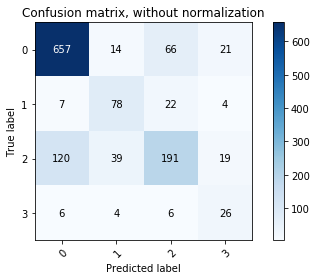

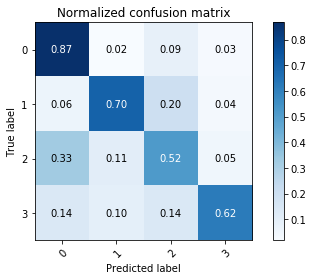

In [83]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels



def plot_confusion_matrix(y_true, y_pred,normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_val, y_pred,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_val, y_pred, normalize=True,
                      title='Normalized confusion matrix')

plt.show()